<a href="https://colab.research.google.com/github/aurimas13/CodeAcademy-AI-Course/blob/main/Notebooks_Finished/Computer_Vision_Project_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Computer Vision Project


# 0. Install

In [1]:
%pip install torch torchvision
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install sklearn
%pip install seaborn
%pip install tqdm
%pip install torchsummary
%pip install torchviz
%pip install pytorch-ignite
%pip install tensorboard
%pip install tensorboardX
%pip install querystring-parser
%pip install slicer
%pip install --upgrade pillow



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is a

UsageError: Line magic function `%python3.11` not found.


## 1. Imports

In [1]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import requests
import requests
from pathlib import Path 

# Measure time
from timeit import default_timer as timer

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: { torchvision.__version__}')

ModuleNotFoundError: No module named 'torch'

## 2. Loading data

We're going to load FashionMNIST dataset for this computer vision problem. 


**Description**: The [original MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services while [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), made by Zalando Research, is a similar setup. Except it contains grayscale images of 10 different kinds of clothing.

![example image of FashionMNIST](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-fashion-mnist-slide.png)
*`torchvision.datasets` contains a lot of example datasets you can use to practice writing computer vision code on. FashionMNIST is one of those datasets. And since it has 10 different image classes (different types of clothing), it's a multi-class classification problem.*


In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [ ]:
# Define classes
class_names = train_data.classes

# Preparing data

### 3.1 Prepare DataLoader

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

In [ ]:
# Setu the batch size hyperparamete
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
      batch_size = BATCH_SIZE, # how many sample per batch?
      shuffle = True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data, 
      batch_size = BATCH_SIZE, 
      shuffle = False # don't necessarily have shuffle the testing data
)

# Let's check what we've created
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloder: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloder: {len(test_dataloader)} batches of {BATCH_SIZE}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x111b5b160>, <torch.utils.data.dataloader.DataLoader object at 0x10c880cd0>)
Length of train dataloder: 1875 batches of 32
Length of test dataloder: 313 batches of 32


### 3.2 Import helper functions

Since we're working on a classification problem, let's bring in prewritten [`helper_functions.py` script](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) and subsequently the `accuracy_fn()` [from here](https://www.learnpytorch.io/02_pytorch_classification/).


In [ ]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
# import accuracy  metric
from helper_functions import accuracy_fn # Note: also could use torchmetrics.Accuracy()

### 3.3 Creating a function to time our experiments

Our timing function will import the [`timeit.default_timer()` function](https://docs.python.org/3/library/timeit.html#timeit.default_timer) from the Python [`timeit` module](https://docs.python.org/3/library/timeit.html).

In [ ]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.4 Create evaluation function

The function will use the model to make predictions on the data in the `DataLoader` and then we can evaluate those predictions using the loss function and accuracy function.

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


# 4. Setup device agnostic-code (for using a GPU if there is one)

We've seen how long it takes to train ma PyTorch model on 60,000 samples on CPU.

Now let's setup some [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#best-practices) for our models and data to run on GPU if it's available.

In [ ]:
# Setup device agnostic coe:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 5. Function for training and testing loops

For the training loop we'll create a function called `train_step()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `test_step()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        

# 6. Convolutional Neural Network (CNN) model

Creating CNN model.

In [ ]:
# Create a convolutional neural network 
class FashionMNISTModel(nn.Module):
    """
    Model architecture is TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
cnn_model = FashionMNISTModel(input_shape=1, 
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)
cnn_model

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# 7. Setup a loss function and optimizer for `cnn_model`

Setuping a loss function and an optimizer.

We'll use the functions as before, `nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification data) and `torch.optim.SGD()` as the optimizer to optimize `CNN_model.parameters()` with a learning rate of `0.1`.

In [ ]:
# Setup losss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),
                            lr=0.1)

# 8. Training and testing `cnn_model_` using our training and test functions

Loss and optimizer ready!

Time to train and test whiule using our `train_step()` and `test_step()` functions we created before.

And also measure the time.


In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_cnn_model = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=cnn_model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_cnn_model = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start_cnn_model,
                                           end=train_time_end_cnn_model,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58781 | Train accuracy: 78.69%
Test loss: 0.40891 | Test accuracy: 85.16%

Epoch: 1
---------
Train loss: 0.36143 | Train accuracy: 86.86%
Test loss: 0.35511 | Test accuracy: 86.82%

Epoch: 2
---------
Train loss: 0.32243 | Train accuracy: 88.31%
Test loss: 0.31614 | Test accuracy: 88.56%

Train time on cpu: 85.155 seconds


## 8.1 Evaluation


In [ ]:
# Get model 2 results# X

cnn_model_results = eval_model(
    model=cnn_model, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) 
cnn_model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3161371350288391,
 'model_acc': 88.55830670926518}

# 9. Make and evaluate random predictions with CNN model

Let's further evaluate our model, `cnn_model` and create a function `make_predictions()` where we can pass the model and some data for it to predict on.


In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)# X

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


Use our `make_predictions()` function to predict on `test_samples`.

Excellent!

And now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.


In [ ]:
# Make predictions on test samples with CNN model
pred_probs = make_predictions(model=cnn_model,
                              data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[3.5622e-07, 2.9647e-07, 3.6690e-07, 8.6100e-07, 7.8417e-08, 9.9970e-01,
         2.2334e-06, 1.2042e-04, 8.8155e-05, 8.4982e-05],
        [3.9813e-02, 6.6415e-01, 1.4076e-03, 1.9907e-01, 4.1271e-02, 1.0095e-04,
         5.2958e-02, 2.4544e-04, 5.5365e-04, 4.3443e-04]])

In [ ]:
# Turn the prediction probabilities into prediction labells by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
# Are predcition in the same form as test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

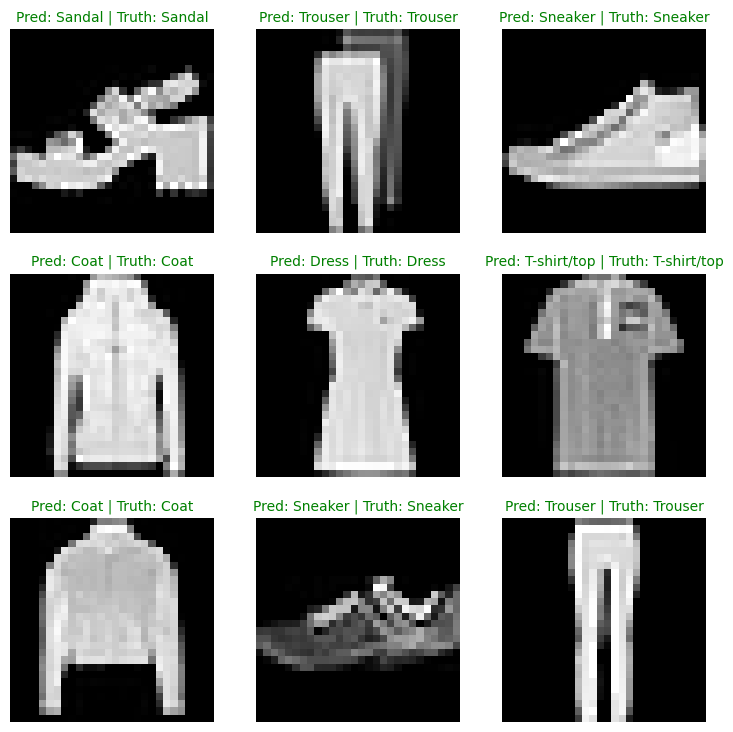

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# 10. Save and load the model

Saving and loading in the model.

Let's save our `cnn_model`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly. 

## 10.1 Save

In [ ]:
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "CNN_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn_model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/CNN_model.pth


## 10.2 Load


In [ ]:
# X
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_cnn_model = FashionMNISTModel(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_cnn_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_cnn_model = loaded_cnn_model.to(device)

## 10.3 Evaluate loaded model


In [ ]:
torch.manual_seed(42)

# Note: this will error due to eval_model() not using device agnostic code
loaded_cnn_model_results = eval_model(
    model=loaded_cnn_model, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
    )
 
loaded_cnn_model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3161371350288391,
 'model_acc': 88.55830670926518}

We can find out if two tensors are close to each other using `torch.isclose()` and passing in a tolerance level of closeness via the parameters `atol` (absolute tolerance) and `rtol` (relative tolerance).

If our model's results are close, the output of `torch.isclose()` should be true.


In [ ]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(cnn_model_results["model_loss"]),
              torch.tensor(loaded_cnn_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)